In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import qt3utils.experiments.rabi
import qt3utils.nidaq.config

In [3]:
import qcsapphire
import qt3rfsynthcontrol
import numpy as np
import matplotlib.pyplot as plt
import time

In [4]:
pulser = qcsapphire.Pulser('COM10')
rfsynth = qt3rfsynthcontrol.QT3SynthHD('COM5')

In [5]:
qt3utils.nidaq.config.reset_daq('Dev1')

In [40]:
freq = 2870e6
N_cycles = 100000
rf_power = -5
clock_terminal = 'PFI0'
spcm_terminal = 'PFI12'

In [14]:
def run_scan(rf_widths, post_data_acq_process = None):
    rfsynth.set_channel_fixed_output(0, rf_power, freq)
    rfsynth.rf_on(0)
    time.sleep(0.1) #wait for RF box to turn on

    data = []
    for rf_width in rf_widths:
        print(rf_width)
       
        full_cycle_ticks, period = qt3utils.experiments.rabi.pulser_setup(pulser, aom_channel = 'A',
                                                                          aom_response_time=900e-9, aom_width = 3e-6, 
                                                                          rf_channel = 'B', rf_width = rf_width,
                                                                         clock_channel = 'C')
        N_samples = full_cycle_ticks * N_cycles
        daq_time = N_samples * period
        print(f'Acquiring {N_samples} at sample period of {period} seconds: total {daq_time} seconds')
        
        edge_config = qt3utils.nidaq.config.EdgeCounter()
        edge_config.configure_counter_period_measure(source_terminal = spcm_terminal,
                                                     N_samples_to_acquire_or_buffer_size = N_samples, 
                                                     clock_terminal = clock_terminal)
        edge_config.create_counter_reader()

        data_buffer = np.zeros(int(N_samples))
        pulser.system.state(1) #turn on the pulser
        time.sleep(0.1) #wait to be sure its on
        edge_config.counter_task.start()
        time.sleep(daq_time*1.1)
        
        read_samples = edge_config.counter_reader.read_many_sample_double(
                                data_buffer,
                                number_of_samples_per_channel=int(N_samples),
                                timeout=5)
        
        edge_config.counter_task.stop()
        
        if post_data_acq_process:
            data_buffer = post_data_acq_process(data_buffer, N_cycles, full_cycle_ticks)
            
        data.append([rf_width, full_cycle_ticks, period, data_buffer])
    
    rfsynth.rf_off(0)
    time.sleep(0.05) #wait for RF box
    return data


In [41]:
def reshape_sum_trace(trace, N_cycles, N_samples_per_cycle):
    data_buffer_by_cycles = trace.reshape((int(N_cycles), int(N_samples_per_cycle)))
    return data_buffer_by_cycles.sum(axis=0)

In [47]:
rf_widths = np.arange(400e-9, 3e-6, 200e-9)

scan_data = run_scan(rf_widths, reshape_sum_trace)

4e-07
Acquiring 3400000.0 at sample period of 2e-07 seconds: total 0.6799999999999999 seconds
6e-07
Acquiring 3600000.0 at sample period of 2e-07 seconds: total 0.72 seconds
8e-07
Acquiring 3800000.0 at sample period of 2e-07 seconds: total 0.76 seconds
1e-06
Acquiring 4000000.0 at sample period of 2e-07 seconds: total 0.7999999999999999 seconds
1.2e-06
Acquiring 4200000.0 at sample period of 2e-07 seconds: total 0.84 seconds
1.4e-06
Acquiring 4400000.0 at sample period of 2e-07 seconds: total 0.88 seconds
1.6e-06
Acquiring 4600000.0 at sample period of 2e-07 seconds: total 0.9199999999999999 seconds
1.8e-06
Acquiring 4800000.0 at sample period of 2e-07 seconds: total 0.96 seconds
2e-06
Acquiring 5000000.0 at sample period of 2e-07 seconds: total 1.0 seconds
2.2e-06
Acquiring 5200000.000000001 at sample period of 2e-07 seconds: total 1.04 seconds
2.4e-06
Acquiring 5400000.0 at sample period of 2e-07 seconds: total 1.0799999999999998 seconds
2.6e-06
Acquiring 5600000.000000001 at sample

In [49]:
scan_data

[[4e-07,
  34.0,
  2e-07,
  array([100978., 100934., 101607., 101350., 101188., 101407., 101605.,
         101422., 101296., 101974., 101346., 100063.,   7960.,   2241.,
          89371.,  89872.,  90580.,  92863.,  94711.,  95943.,  97570.,
          98348.,  98680.,  99716.,  99676., 100311., 100395., 100341.,
          99555.,   7923.,   2221.,  98502., 101089., 100715.])],
 [6e-07,
  36.0,
  2e-07,
  array([103187., 103173., 103171., 103203., 103450., 103253., 103271.,
         103208., 102980., 101551.,   8075.,   1000.,   2291.,  91036.,
          91932.,  92312.,  94630.,  96678.,  98341.,  99496.,  99976.,
         100774., 101831., 101971., 102352., 101513., 101187., 101301.,
           7988.,   1010.,   2189.,  99891., 102851., 102969., 102959.,
         102951.])],
 [8e-07,
  38.0,
  2e-07,
  array([102722., 102760., 102959., 102846., 103095., 101937.,   7991.,
           1112.,   1053.,   2245., 101574., 104576., 104502., 104076.,
         104717., 104585., 104673., 104790.

In [50]:
import pickle

In [55]:
np.save('scan_data', np.array(scan_data))

C:\Users\QT3\AppData\Local\Temp\ipykernel_552\1111870500.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save('scan_data', np.array(scan_data))


In [59]:
lscan_data = np.load('scan_data.npy', allow_pickle=True)

In [60]:
def plot_rolled_trace(trace, N_cycles, N_samples_per_cycle, clock_rate, shift=0):
    trace = np.roll(trace,shift)
    plt.plot(np.arange(N_samples_per_cycle) / clock_rate, trace/N_cycles * clock_rate)

In [62]:
lscan_data

array([[4e-07, 34.0, 2e-07,
        array([100978., 100934., 101607., 101350., 101188., 101407., 101605.,
               101422., 101296., 101974., 101346., 100063.,   7960.,   2241.,
                89371.,  89872.,  90580.,  92863.,  94711.,  95943.,  97570.,
                98348.,  98680.,  99716.,  99676., 100311., 100395., 100341.,
                99555.,   7923.,   2221.,  98502., 101089., 100715.])        ],
       [6e-07, 36.0, 2e-07,
        array([103187., 103173., 103171., 103203., 103450., 103253., 103271.,
               103208., 102980., 101551.,   8075.,   1000.,   2291.,  91036.,
                91932.,  92312.,  94630.,  96678.,  98341.,  99496.,  99976.,
               100774., 101831., 101971., 102352., 101513., 101187., 101301.,
                 7988.,   1010.,   2189.,  99891., 102851., 102969., 102959.,
               102951.])                                                     ],
       [8e-07, 38.0, 2e-07,
        array([102722., 102760., 102959., 102846., 103

ValueError: x and y must have same first dimension, but have shapes (53,) and (52,)

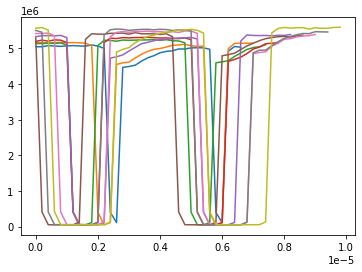

In [65]:
for d in lscan_data:

    plot_rolled_trace(d[3], N_cycles, d[1], 1./d[2],0)

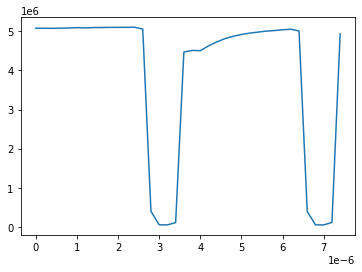

In [39]:
plot_rolled_trace(scan_data[2][3], N_cycles, scan_data[2][1], 1./scan_data[2][2], 0)

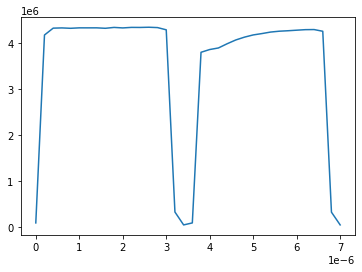

In [468]:
plot_rolled_trace(scan_data[1][3], N_cycles, scan_data[1][1], 1./scan_data[1][2],4)

2870000000.0


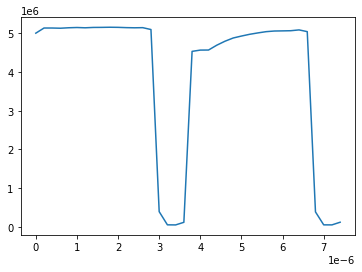

In [434]:
shift = 0
#data  = cwodmrs_raw[0]

freq = scan_data[0][0]
trace = scan_data[0][1]

print(freq)
data_buffer_by_cycles = np.roll(trace,shift).reshape((int(N_cycles), int(full_cycle_ticks)))
plt.plot(np.arange(full_cycle_ticks) * period,data_buffer_by_cycles.mean(axis=0) * 1/period)


2870000000.0


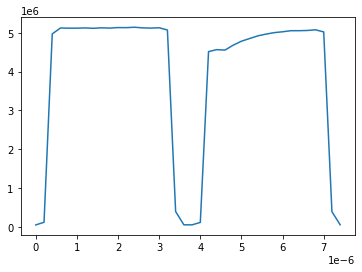

In [438]:
shift = 0
#data  = cwodmrs_raw[0]

freq = scan_data[0][0]
trace = scan_data[0][1]

print(freq)
data_buffer_by_cycles = np.roll(trace,shift).reshape((int(N_cycles), int(full_cycle_ticks)))
plt.plot(np.arange(full_cycle_ticks) * period,data_buffer_by_cycles.mean(axis=0) * 1/period)
